In [1]:
import sys
sys.path.append('./scripts/')
from dp_policy_agent import *
from dynamic_programming import *

In [2]:
class QmdpAgent(DpPolicyAgent): ###qmdp3
    def __init__(self, time_interval, estimator, goal, puddles, sampling_num=10, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 puddle_coef=1000000.0, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T): 
        super().__init__(time_interval, estimator, goal, puddle_coef, widths, lowerleft, upperright)
        
        self.dp = DynamicProgramming(widths, goal, puddles, time_interval, sampling_num)
        self.dp.value_function = self.init_value()
        self.evaluations = np.array([0.0, 0.0, 0.0])
        self.current_value = 0.0
        
        self.history = [(0, 0)] #行動の履歴を記録
        
    def init_value(self):
        tmp = np.zeros(self.dp.index_nums)
        for line in open("./data/dp_value.txt", "r"):
            d = line.split()
            tmp[int(d[0]), int(d[1]), int(d[2])] = float(d[3])
            
        return tmp
    
    def evaluation(self, action, indexes):
        return sum([self.dp.action_value(action, i, out_penalty=False) for i in indexes])/len(indexes)
        
    def policy(self, pose, goal=None): #追加（引数poseは使わない）
        indexes = [self.to_index(p.pose, self.pose_min, self.index_nums, self.widths) for p in self.estimator.particles]
        self.current_value = sum([self.dp.value_function[i] for i in indexes])/len(indexes)
        self.evaluations = [self.evaluation(a, indexes) for a in self.dp.actions]
        self.history.append(self.dp.actions[np.argmax(self.evaluations)]) #ここから変更。historyにQ-MDPで選んだ行動を追記
        
        if self.history[-1][0] + self.history[-2][0] == 0.0 and self.history[-1][1] + self.history[-2][1] == 0.0: #2回の行動で停止していたら前進
            return (1.0, 0.0)
        
        return self.history[-1]
    
    def draw(self, ax, elems):
        super().draw(ax, elems)
        elems.append(ax.text(-4.5, -4.6, "{:.3} => [{:.3}, {:.3}, {:.3}]".format(self.current_value, *self.evaluations), fontsize=8))

In [3]:
def trial(animation):
    time_interval = 0.1
    world = PuddleWorld(120, time_interval, debug=not animation) 

    ##ランドマークの追加（意地悪な位置に）##
    m = Map()
    for ln in [(1,4), (4,1), (-4,-4)]: m.append_landmark(Landmark(*ln))
    world.append(m) 
    
    ##ゴール・水たまりの追加（これは特に変更なし）##
    goal = Goal(-3,-3)
    puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)] 
    world.append(goal)
    world.append(puddles[0]) 
    world.append(puddles[1])
    
    ##ロボットを作る##
    init_pose = np.array([2.5, 2.5, 0]).T
    pf = Mcl(m, init_pose, 100)
    a = QmdpAgent(time_interval, pf, goal, puddles) 
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="black")

    world.append(r)
    world.draw()
  #  world.ani.save('/tmp/anm.gif', writer='imagemagick', fps=10)
    
    return a

<IPython.core.display.Javascript object>


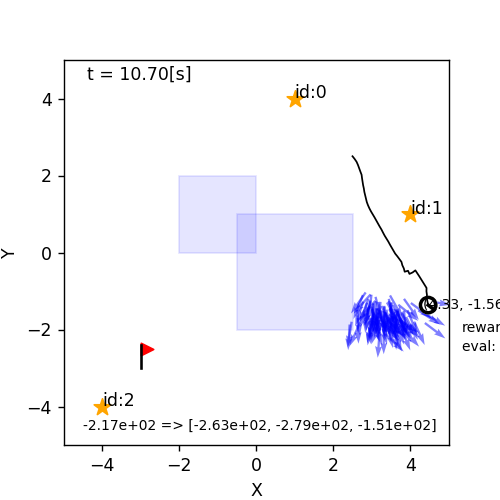

In [5]:
trial(True)

In [ ]:
def evaluation():
    with open("qmdp_heuristic_result.txt", "w") as f:
        num = 1000
        for i in range(num):
            a = trial(False)
            f.write("{} {}\n".format(a.total_reward+a.final_value, a.in_goal))
            f.flush()

In [ ]:
evaluation()